In [1]:
import datetime, warnings, scipy
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.metrics import roc_auc_score,confusion_matrix,f1_score
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
# from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('flight_delays_train.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info

Dataframe dimensions: (100000, 9)


,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
column type,object,object,object,int64,object,object,object,int64,object


In [3]:
unique_counts = df.nunique()
print(unique_counts)

Month                  12
DayofMonth             31
DayOfWeek               7
DepTime              1300
UniqueCarrier          22
Origin                289
Dest                  289
Distance             1310
dep_delayed_15min       2
dtype: int64


In [4]:
value_counts_origin = df['Origin'].value_counts()
print(value_counts_origin)
value_counts_dest = df['Dest'].value_counts()
print(value_counts_dest)

Origin
ATL    5834
ORD    4870
DFW    4270
LAX    3259
IAH    3048
       ... 
VIS       1
WYS       1
ILG       1
VCT       1
ADK       1
Name: count, Length: 289, dtype: int64
Dest
ATL    5795
ORD    4933
DFW    4337
LAX    3205
IAH    3056
       ... 
LWB       1
TEX       1
ACK       1
TTN       1
VCT       1
Name: count, Length: 289, dtype: int64


In [5]:
df2 = df[df['dep_delayed_15min'] == 'Y']
value_counts_origin_yes = df2['Origin'].value_counts()
print(value_counts_origin_yes)
value_counts_dest_yes = df2['Dest'].value_counts()
print(value_counts_dest_yes)

Origin
ATL    1506
ORD    1254
DFW     902
DEN     575
LAX     552
       ... 
ISO       1
GST       1
CDV       1
ADK       1
HLN       1
Name: count, Length: 269, dtype: int64
Dest
ATL    1281
ORD    1072
DFW     656
EWR     584
LAX     525
       ... 
CIC       1
BGM       1
HTS       1
FLO       1
BRW       1
Name: count, Length: 276, dtype: int64


In [6]:
prob_delay_origin = value_counts_origin_yes/value_counts_origin
prob_delay_origin = prob_delay_origin.sort_values(ascending=True)
print(prob_delay_origin)
prob_delay_dest = value_counts_dest_yes/value_counts_dest
prob_delay_dest = prob_delay_dest.sort_values(ascending=True)
print(prob_delay_dest)


Origin
GTF    0.022222
ITO    0.029412
HLN    0.032258
LIH    0.032680
BRO    0.035714
         ...   
TXK         NaN
VCT         NaN
VIS         NaN
WRG         NaN
WYS         NaN
Name: count, Length: 289, dtype: float64
Dest
SMX    0.031250
ITO    0.039474
FCA    0.044444
BQK    0.047619
GGG    0.055556
         ...   
SOP         NaN
SPS         NaN
TEX         NaN
TUP         NaN
VCT         NaN
Name: count, Length: 289, dtype: float64


Now adding new features created.

In [7]:
def get_season(month):
    if month in [12, 1, 11]: return 'Winter'
    elif month in [2, 3, 4]: return 'Spring'
    elif month in [5, 7, 6, 8]: return 'Summer'
    else: return 'Fall'


# to add season feature

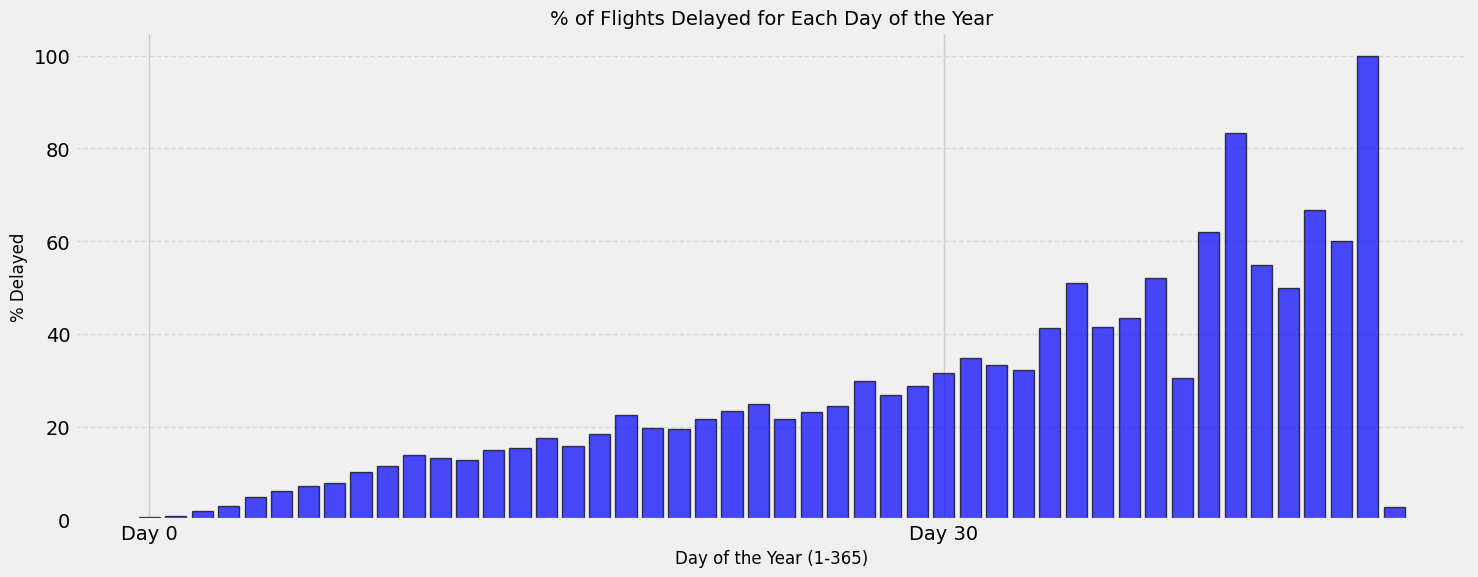

   Month  DayofMonth  DayOfWeek  DepTime UniqueCarrier Origin Dest  Distance  \
0      8          21          7       30            AA    ATL  DFW       732   
1      4          20          3       22            US    PIT  MCO       834   
2      9           2          5       19            XE    RDU  CLE       416   
3     11          25          6       11            OO    DEN  MEM       872   
4     10           7          6       28            WN    MDW  OMA       423   

   dep_delayed_15min  Origin_counts  Origin_prob  Dest_counts  Dest_prob  \
0                  0           5834     0.258142         4337   0.151257   
1                  0            688     0.171512         1728   0.184028   
2                  0            868     0.184332         1218   0.175698   
3                  0           2973     0.193407          629   0.149444   
4                  1           1366     0.251098          311   0.260450   

   Is_Weekend  Season   Day_sin  Date_sin  Month_sin      Time

In [8]:
df['Origin_counts'] = df['Origin'].map(value_counts_origin)
df['Origin_prob'] = df['Origin'].map(prob_delay_origin)
df['Dest_counts'] = df['Dest'].map(value_counts_dest)
df['Dest_prob'] = df['Dest'].map(prob_delay_dest)
df['DayOfWeek'] = df['DayOfWeek'].astype(str).str.replace('c-', '').astype(int) #encoding month
df['Is_Weekend'] = df['DayOfWeek'].isin([6,7]).astype(int) # weekend feature
df['Month'] = df['Month'].astype(str).str.replace('c-', '').astype(int) #encoding month
df['DayofMonth'] = df['DayofMonth'].astype(str).str.replace('c-', '').astype(int)
df['Season'] = df['Month'].apply(get_season)
label_encoder = LabelEncoder()
df['dep_delayed_15min'] = label_encoder.fit_transform(df['dep_delayed_15min'])#how have the values of k1,k2,k3,k4 been chosen?
k1 = 0.8
df['Day_sin'] = np.sin(2*np.pi*df['DayOfWeek']/7 + k1*np.pi)#what are these sin functions?
k2 = 0.5
df['Date_sin'] = np.sin(2 * np.pi * df['DayofMonth'] / 15 + k2*np.pi)
k3 = 0.1
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12 + k3*np.pi)
k4 = 1
df['Time'] = np.sin(2 * np.pi * df['DepTime'] / 2400 + k4*np.pi)
df['Origin_delays'] = df['Origin_counts'] * df['Origin_prob']#what is the use of origin counts, delay counts once calculated origin and dest delays?
df['Dest_delays'] = df['Dest_counts'] * df['Dest_prob']
df.fillna(0,inplace=True)



df['dep_delayed_15min'] = df['dep_delayed_15min'].astype(int)

# Create a 'Date' feature representing each unique day of the year (1-365)
df['DepTime'] = df['DepTime']//48  # Approximation assuming 30 days per month
df['DepTime'] = (df['DepTime'] + 38)%48

# Group by 'Date' and calculate the percentage of delayed flights
delay_percentage = df.groupby('DepTime')['dep_delayed_15min'].mean()*100

# Plot the histogram
plt.figure(figsize=(15, 6))
plt.bar(delay_percentage.index, delay_percentage, color='blue', alpha=0.7, edgecolor='black')
plt.title('% of Flights Delayed for Each Day of the Year', fontsize=14)
plt.xlabel('Day of the Year (1-365)', fontsize=12)
plt.ylabel('% Delayed', fontsize=12)
plt.xticks(ticks=range(0, 48, 30), labels=[f'Day {i}' for i in range(0, 48, 30)])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print(df.head())

Class distribution before SMOTE: dep_delayed_15min
0    64734
1    15266
Name: count, dtype: int64
Class distribution after SMOTE: dep_delayed_15min
0    64734
1    64734
Name: count, dtype: int64
f1-score of Random Forest model: 0.3304
roc_auc-score of Random Forest model: 0.7455
Feature: Month, Importance: 0.0374
Feature: DayofMonth, Importance: 0.0572
Feature: DayOfWeek, Importance: 0.0328
Feature: DepTime, Importance: 0.2012
Feature: Distance, Importance: 0.0695
Feature: Origin_prob, Importance: 0.0770
Feature: Dest_prob, Importance: 0.0767
Feature: Is_Weekend, Importance: 0.0048
Feature: Day_sin, Importance: 0.0508
Feature: Date_sin, Importance: 0.0476
Feature: Month_sin, Importance: 0.0427
Feature: Time, Importance: 0.1507
Feature: Origin_delays, Importance: 0.0701
Feature: Dest_delays, Importance: 0.0649
Feature: Season_Spring, Importance: 0.0044
Feature: Season_Summer, Importance: 0.0065
Feature: Season_Winter, Importance: 0.0057


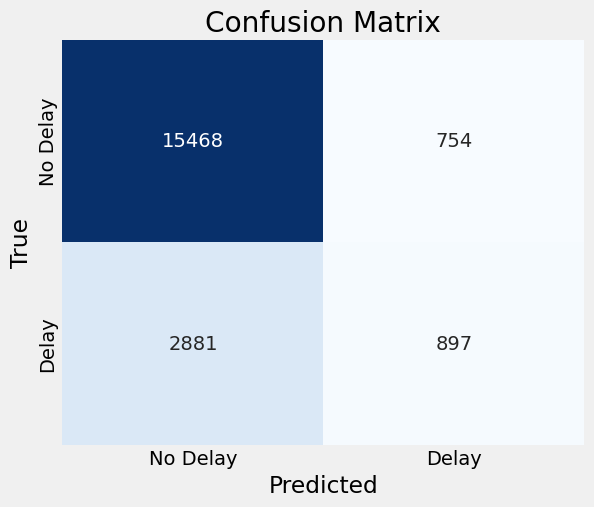

In [9]:
data = df.copy()
data.drop(columns=['Origin', 'Dest','UniqueCarrier','Origin_counts','Dest_counts'],inplace=True)#delete dest, origin counts as well
data = pd.get_dummies(data, columns=['Season'], drop_first=True)
X = data.drop('dep_delayed_15min', axis=1)  # Features
y = data['dep_delayed_15min']  # Target
smote = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
x_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution before SMOTE:", y_train.value_counts())
print("Class distribution after SMOTE:", pd.Series(y_train_resampled).value_counts())
rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(x_train_resampled, y_train_resampled)
y_pred_prob = rf.predict_proba(X_test)[:,1]
y_pred = np.where(y_pred_prob >0.5,1,0)
roc_auc = roc_auc_score(y_test, y_pred_prob)
f1 = f1_score(y_test,y_pred)
print(f"f1-score of Random Forest model: {f1:.4f}")
print(f"roc_auc-score of Random Forest model: {roc_auc:.4f}")
feature_importances = rf.feature_importances_

for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")


cm = confusion_matrix(y_test, y_pred)

# 2. Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Delay", "Delay"], yticklabels=["No Delay", "Delay"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [11]:
# As Random forset was our Best model we used to for the final prediction of the test.csv. A submission will be generated r
# representing our Output.


def preprocess(df):
    df['Origin_counts'] = df['Origin'].map(value_counts_origin)
    df['Origin_prob'] = df['Origin'].map(prob_delay_origin)
    df['Dest_counts'] = df['Dest'].map(value_counts_dest)
    df['Dest_prob'] = df['Dest'].map(prob_delay_dest)
    df['DayOfWeek'] = df['DayOfWeek'].astype(str).str.replace('c-', '').astype(int) #encoding month
    df['Is_Weekend'] = df['DayOfWeek'].isin([6,7]).astype(int) # weekend feature
    df['Month'] = df['Month'].astype(str).str.replace('c-', '').astype(int) #encoding month
    df['DayofMonth'] = df['DayofMonth'].astype(str).str.replace('c-', '').astype(int)
    k1 = 0.8
    df['Day_sin'] = np.sin(2*np.pi*df['DayOfWeek']/7 + k1*np.pi)
    k2 = 0.5
    df['Date_sin'] = np.sin(2 * np.pi * df['DayofMonth'] / 15 + k2*np.pi)
    k3 = 0.1
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12 + k3*np.pi)
    k4 = 1
    df['Time'] = np.sin(2 * np.pi * df['DepTime'] / 2400 + k4*np.pi)
    df['Origin_delays'] = df['Origin_counts'] * df['Origin_prob']
    df['Dest_delays'] = df['Dest_counts'] * df['Dest_prob']
    df.fillna(0,inplace=True)
    df['Season'] = df['Month'].apply(get_season)
    # Create a 'Date' feature representing each unique day of the year (1-365)
    df['DepTime'] = df['DepTime']//48  # Approximation assuming 30 days per month
    df['DepTime'] = (df['DepTime'] + 38)%48
    return df


test_data = pd.read_csv("flight_delays_test.csv")
preprocess(test_data)
test_data.drop(columns=['Origin', 'Dest','UniqueCarrier','Origin_counts','Dest_counts'],inplace=True)
print(test_data.head())
test_data = pd.get_dummies(test_data, columns=['Season'], drop_first=True)
test_data = scaler.transform(test_data)
submission = rf.predict_proba(test_data)[:,1]
print(submission)
submission_df = pd.DataFrame(submission,columns=["delay_probablity"])
submission_df.to_csv("submission.csv",index = False)

   Month  DayofMonth  DayOfWeek  DepTime  Distance  Origin_prob  Dest_prob  \
0      7          25          3        2       598     0.205882   0.168789   
1      4          17          2        5      1235     0.217270   0.209272   
2     12           2          7        3       577     0.195531   0.217312   
3      3          25          7       23       377     0.188377   0.231544   
4      6           6          3       21       258     0.257495   0.200676   

   Is_Weekend   Day_sin  Date_sin  Month_sin      Time  Origin_delays  \
0           0 -0.880596 -0.500000  -0.743145 -0.999229           21.0   
1           0 -0.919528  0.669131   0.669131 -0.934515          546.0   
2           1  0.587785  0.669131   0.309017 -0.991100           35.0   
3           1  0.587785 -0.500000   0.951057  0.883766          282.0   
4           0 -0.880596 -0.809017  -0.309017  0.716302         1254.0   

   Dest_delays  Season  
0        464.0  Summer  
1        158.0  Spring  
2       1072.0  W

[False False False ... False False False]


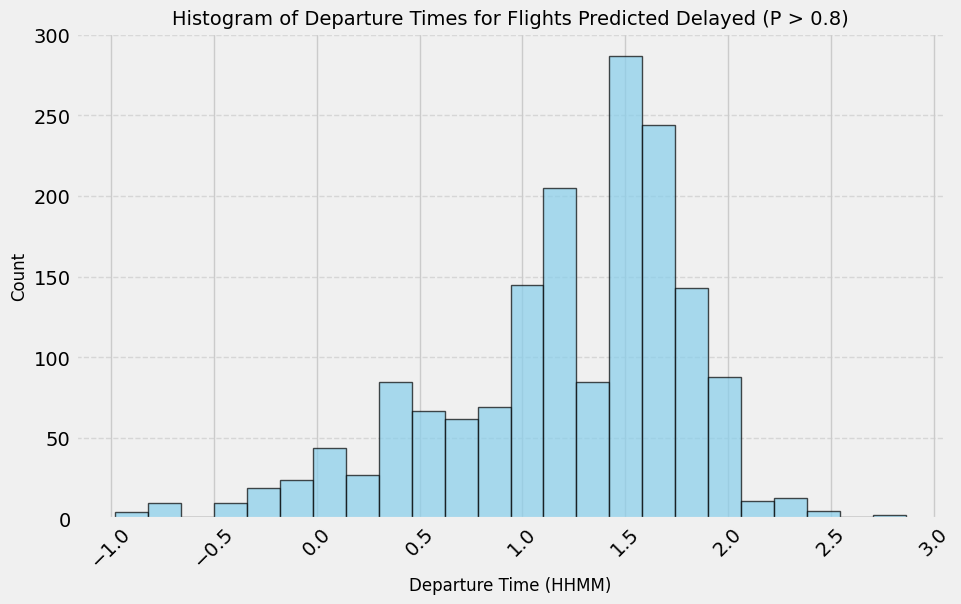

In [ ]:
high_prob_indices = y_pred_prob > 0.5
print(high_prob_indices)
high_prob_times = X_test[high_prob_indices,3]  # Assuming 'DepTime' is in X_test

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(high_prob_times, bins=24, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Departure Times for Flights Predicted Delayed (P > 0.8)', fontsize=14)
plt.xlabel('Departure Time (HHMM)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
train_pred = rf.predict_proba(x_train_resampled)[:,1]
train_roc_auc = roc_auc_score(y_train_resampled,train_pred)
print(train_roc_auc)

f1-score of Random Forest model: 0.3605
roc_auc-score of Random Forest model: 0.6069
Feature: Month, Importance: 0.0374
Feature: DayofMonth, Importance: 0.0572
Feature: DayOfWeek, Importance: 0.0328
Feature: DepTime, Importance: 0.2012
Feature: Distance, Importance: 0.0695
Feature: Origin_prob, Importance: 0.0770
Feature: Dest_prob, Importance: 0.0767
Feature: Is_Weekend, Importance: 0.0048
Feature: Day_sin, Importance: 0.0508
Feature: Date_sin, Importance: 0.0476
Feature: Month_sin, Importance: 0.0427
Feature: Time, Importance: 0.1507
Feature: Origin_delays, Importance: 0.0701
Feature: Dest_delays, Importance: 0.0649
Feature: Season_Spring, Importance: 0.0044
Feature: Season_Summer, Importance: 0.0065
Feature: Season_Winter, Importance: 0.0057


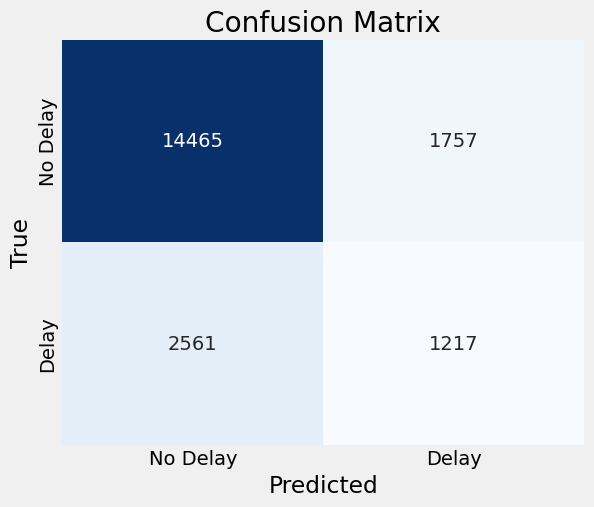

In [ ]:
adaboost = AdaBoostClassifier(n_estimators=400, learning_rate=1.0, random_state=42)
adaboost.fit(x_train_resampled, y_train_resampled)
y_pred = adaboost.predict(X_test)
y_prob = adaboost.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)
print(f"f1-score of Random Forest model: {f1:.4f}")
print(f"roc_auc-score of Random Forest model: {roc_auc:.4f}")
feature_importances = rf.feature_importances_

for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")


cm = confusion_matrix(y_test, y_pred)

# 2. Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Delay", "Delay"], yticklabels=["No Delay", "Delay"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#SVC
from sklearn.model_selection import KFold
from sklearn.svm import SVC
data = df.copy()
data.drop(columns=['UniqueCarrier', 'Origin', 'Dest','Origin_counts','Dest_counts'],inplace=True)
data = pd.get_dummies(data, columns=['Season'], drop_first=True)
X = data.drop('dep_delayed_15min', axis=1)  # Features
y = data['dep_delayed_15min']  # Target
smote = SMOTE(random_state=42)
scaler = StandardScaler()
kf=KFold(n_splits=5)
lr=SVC(kernel='rbf',C=10)
score_lr=[]
f1_score_array=[]
roc_auc_scores=[]

for train_indices,test_indices in kf.split(X['Month']):
    X_train=X.iloc[train_indices]
    y_train=y.iloc[train_indices]
    X_test=X.iloc[test_indices]
    y_test=y.iloc[test_indices]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    x_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    lr.fit(x_train_resampled,y_train_resampled)
    y_pred = lr.predict(X_test)
    y_prob = lr.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    f1_score_array.append(f1)
    roc_auc_scores.append(roc_auc)
print("Average f1: ",sum(f1_score_array)/len(f1_score_array))
print("Min f1: ",min(f1_score_array))
print("Max f1: ",max(f1_score_array))
print("Average roc_auc: ",sum(roc_auc_scores)/len(roc_auc_scores))
print("Min roc_auc: ",min(roc_auc_scores))
print("Max roc_auc: ",max(roc_auc_scores))

In [ ]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
from joblib import Parallel, delayed
import pandas as pd

def process_fold(train_indices, test_indices, X, y, scaler, smote, svc):
    """Process a single fold of the cross-validation"""
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]

    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTE
    x_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    # Train and predict
    svc.fit(x_train_resampled, y_train_resampled)
    y_pred = svc.predict(X_test_scaled)
    y_prob = svc.decision_function(X_test_scaled)  # Faster than predict_proba

    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)

    return f1, roc_auc

def evaluate_model(df, n_jobs=-1):
    """Evaluate the SVC model with parallel processing"""
    # Data preprocessing
    print(len(df))
    data = df.copy()[:30000]
    data.drop(columns=['UniqueCarrier', 'Origin', 'Dest', 'Origin_counts', 'Dest_counts'], inplace=True)
    data = pd.get_dummies(data, columns=['Season'], drop_first=True)

    # Split features and target
    X = data.drop('dep_delayed_15min', axis=1)
    y = data['dep_delayed_15min']

    # Initialize components
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    smote = SMOTE(random_state=42)
    scaler = StandardScaler()
    svc = SVC(
        kernel='rbf',
        C=10,
        cache_size=2000,  # Increase cache size for faster computation
        probability=False  # Disable probability estimates for speed
    )

    # Parallel processing of folds
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_fold)(
            train_idx, test_idx, X, y,
            StandardScaler(), SMOTE(random_state=42),
            SVC(kernel='rbf', C=10, cache_size=2000, probability=False)
        )
        for train_idx, test_idx in kf.split(X)
    )

    # Unpack results
    f1_scores, roc_auc_scores = zip(*results)

    # Calculate and return metrics
    metrics = {
        'avg_f1': np.mean(f1_scores),
        'min_f1': np.min(f1_scores),
        'max_f1': np.max(f1_scores),
        'avg_roc_auc': np.mean(roc_auc_scores),
        'min_roc_auc': np.min(roc_auc_scores),
        'max_roc_auc': np.max(roc_auc_scores)
    }

    return metrics

# Usage example:
metrics = evaluate_model(df)
for metric_name, value in metrics.items():
     print(f"{metric_name}: {value}")

100000
avg_f1: 0.38933399636937793
min_f1: 0.38633102908569195
max_f1: 0.3923369636530639
avg_roc_auc: 0.6766348110695308
min_roc_auc: 0.674601006777608
max_roc_auc: 0.6786686153614536


In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
data = df.copy()
data.drop(columns=['UniqueCarrier', 'Origin', 'Dest','Origin_counts','Dest_counts'],inplace=True)
data = pd.get_dummies(data, columns=['Season'], drop_first=True)
X = data.drop('dep_delayed_15min', axis=1)  # Features
y = data['dep_delayed_15min']  # Target
smote = SMOTE(random_state=42)
scaler = StandardScaler()
kf=KFold(n_splits=2)
lr=KNeighborsClassifier(n_neighbors=10)
score_lr=[]
f1_score_array=[]
roc_auc_scores=[]
for train_indices,test_indices in kf.split(X['Month']):
    X_train=X.iloc[train_indices]
    y_train=y.iloc[train_indices]
    X_test=X.iloc[test_indices]
    y_test=y.iloc[test_indices]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    x_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    lr.fit(x_train_resampled,y_train_resampled)
    y_pred = lr.predict(X_test)
    y_prob = lr.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    f1_score_array.append(f1)
    roc_auc_scores.append(roc_auc)
print("Average f1: ",sum(f1_score_array)/len(f1_score_array))
print("Min f1: ",min(f1_score_array))
print("Max f1: ",max(f1_score_array))
print("Average roc_auc: ",sum(roc_auc_scores)/len(roc_auc_scores))
print("Min roc_auc: ",min(roc_auc_scores))
print("Max roc_auc: ",max(roc_auc_scores))

Average f1:  0.37751887002958817
Min f1:  0.3725221906465986
Max f1:  0.38251554941257776
Average roc_auc:  0.6144962678489643
Min roc_auc:  0.6112142784877723
Max roc_auc:  0.6177782572101562


In [ ]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
data = df.copy()
data.drop(columns=['UniqueCarrier', 'Origin', 'Dest','Origin_counts','Dest_counts'],inplace=True)
data = pd.get_dummies(data, columns=['Season'], drop_first=True)
X = data.drop('dep_delayed_15min', axis=1)  # Features
y = data['dep_delayed_15min']  # Target
smote = SMOTE(random_state=42)
scaler = StandardScaler()
kf=KFold(n_splits=5)
lr=LogisticRegression()
score_lr=[]
f1_score_array=[]
roc_auc_scores=[]
for train_indices,test_indices in kf.split(X['Month']):
    X_train=X.iloc[train_indices]
    y_train=y.iloc[train_indices]
    X_test=X.iloc[test_indices]
    y_test=y.iloc[test_indices]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    x_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    lr.fit(x_train_resampled,y_train_resampled)
    y_pred = lr.predict(X_test)
    y_prob = lr.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    f1_score_array.append(f1)
    roc_auc_scores.append(roc_auc)
print("Average f1: ",sum(f1_score_array)/len(f1_score_array))
print("Min f1: ",min(f1_score_array))
print("Max f1: ",max(f1_score_array))
print("Average roc_auc: ",sum(roc_auc_scores)/len(roc_auc_scores))
print("Min roc_auc: ",min(roc_auc_scores))
print("Max roc_auc: ",max(roc_auc_scores))

Average f1:  0.4152109918450009
Min f1:  0.40446690577111183
Max f1:  0.42488716956802064
Average roc_auc:  0.6520003276296522
Min roc_auc:  0.6460848620426989
Max roc_auc:  0.6588554829406392
